## ***Twitter Sentiment Analysis***

Dataset Link: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data

# **Import Libraries**

In [ ]:
!pip install nltk
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Loading the Dataset**

In [ ]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_Content']

In [ ]:
Data_train = pd.read_csv("/content/twitter_training.csv",names=column_names)
Data_train


,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [ ]:
Data_valid = pd.read_csv("/content/twitter_validation.csv",names=column_names)
Data_valid


,Tweet_ID,Entity,Sentiment,Tweet_Content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


# **Exploratory Data Analysis**

In [ ]:
Data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_Content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
Data_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       1000 non-null   int64 
 1   Entity         1000 non-null   object
 2   Sentiment      1000 non-null   object
 3   Tweet_Content  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [ ]:
Data_train.describe()

,Tweet_ID
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [ ]:
Data_valid.describe()

,Tweet_ID
count,1000.000000
mean,6432.088000
std,3728.310569
min,6.000000
25%,3247.750000
50%,6550.000000
75%,9661.750000
max,13197.000000


In [ ]:
Data_train.sample(10)

,Tweet_ID,Entity,Sentiment,Tweet_Content
73336,8962,Nvidia,Neutral,Team Nvidia ’ s new driver system gives player...
32286,7540,LeagueOfLegends,Negative,"@LeagueOfLegends please fix your login, litera..."
36785,8310,Microsoft,Neutral,"Microsoft Outage Locks in Review of Safe<unk>,..."
23034,4347,CS-GO,Positive,Help me win this awesome CS:GO giveaway from I...
20404,12693,WorldOfCraft,Neutral,"2010 US Steel WoW Token Price : 80 151, 057g. ..."
69765,3953,Cyberpunk2077,Irrelevant,"Super misleading headline. Of course, as alwa..."
72943,8895,Nvidia,Positive,I used this @ NVIDIAGFN service when I won a B...
21400,4063,CS-GO,Negative,@CSGO @valve should fix loss problem with both...
32203,7526,LeagueOfLegends,Negative,Haha League of Legends? Rather a bad game
64135,7789,MaddenNFL,Negative,"Dear @ EASPORTS _ MUT @ EAMaddenNFL,.. Fix you..."


In [ ]:
Data_valid.sample(10)

,Tweet_ID,Entity,Sentiment,Tweet_Content
840,6773,Fortnite,Negative,What the actual heck @fortnite you clearly hav...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
241,3675,Cyberpunk2077,Irrelevant,Quality tweet.
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
498,2008,CallOfDuty,Irrelevant,It was ab fab seeing the 6 bungalows built in ...
108,10078,PlayerUnknownsBattlegrounds(PUBG),Negative,Even tae playing pubg I won’t ever installing ...
32,7024,johnson&johnson,Negative,"Johnson & Johnson, knowingly sold baby powder ..."
320,6291,FIFA,Positive,#WorldCupAtHome: Five African matches you woul...
589,6795,Fortnite,Negative,Hi @FortniteGame \n\nI get that you wont remov...
263,410,ApexLegends,Neutral,Squadwipe turn n burn #ApexLegends #XboxShare ...


In [ ]:
# information of the dataset
print(f"Train dataset shape: {Data_train.shape}")
print(f"Validation dataset shape: {Data_valid.shape}")

Train dataset shape: (74682, 4)
Validation dataset shape: (1000, 4)


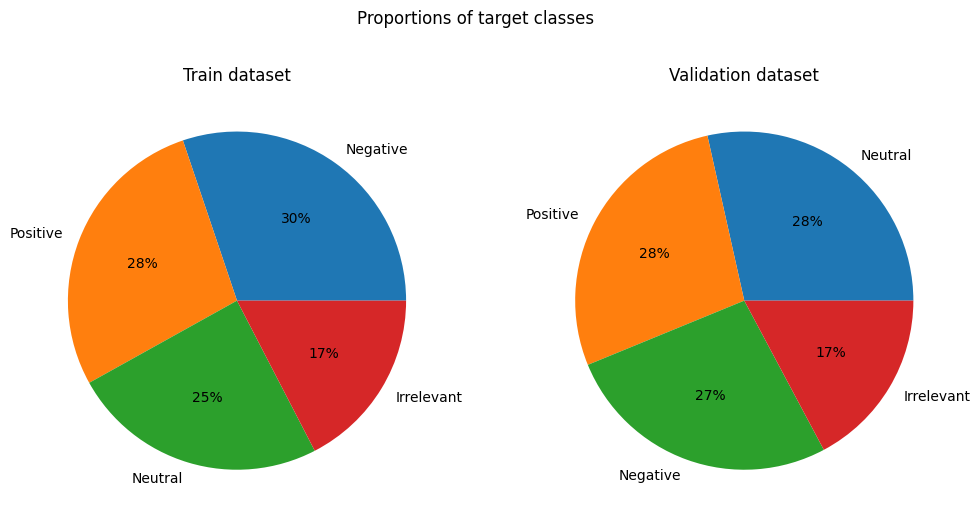

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(12,6))

ax[0].pie(Data_train['Sentiment'].value_counts(),labels=Data_train['Sentiment'].value_counts().index,autopct='%.f%%')
ax[1].pie(Data_valid['Sentiment'].value_counts(),labels=Data_valid['Sentiment'].value_counts().index,autopct='%.f%%')

fig.suptitle("Proportions of target classes")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

In [ ]:
Data_train['Sentiment']=Data_train['Sentiment'].astype(str)
Data_train['Tweet_Content']=Data_train['Tweet_Content'].astype(str)

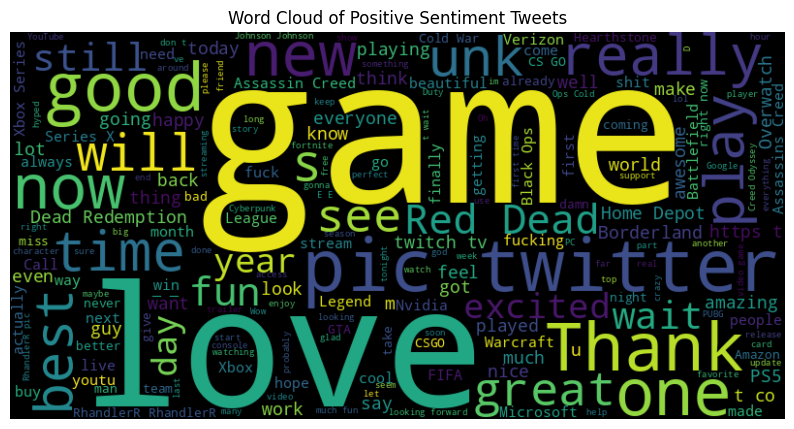

In [ ]:
positive_tweets = Data_train[Data_train["Sentiment"] == "Positive"]["Tweet_Content"]
positive_tweets=positive_tweets.astype(str)
# Join all the positive tweets into a single string
positive_text = ','.join(positive_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400).generate(positive_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Sentiment Tweets')
plt.show()

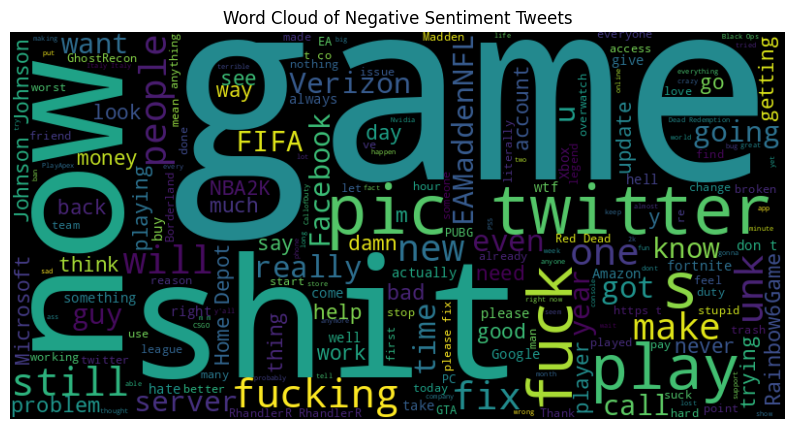

In [ ]:
negative_tweets = Data_train[Data_train["Sentiment"] == "Negative"]["Tweet_Content"]
negative_tweets=negative_tweets.astype(str)
# Join all the Negative tweets into a single string
negative_text = ','.join(negative_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400).generate(negative_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Sentiment Tweets')
plt.show()

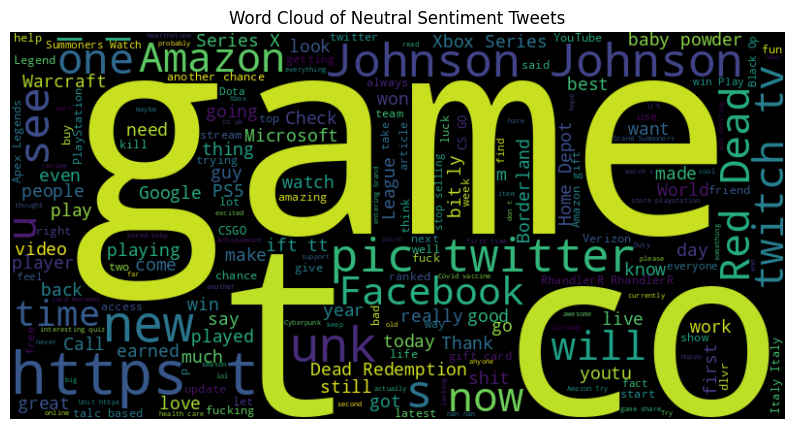

In [ ]:
neutral_tweets = Data_train[Data_train["Sentiment"] == "Neutral"]["Tweet_Content"]
neutral_tweets=neutral_tweets.astype(str)

# Join all the Neutral tweets into a single string
neutral_text = ','.join(neutral_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400).generate(neutral_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Sentiment Tweets')
plt.show()

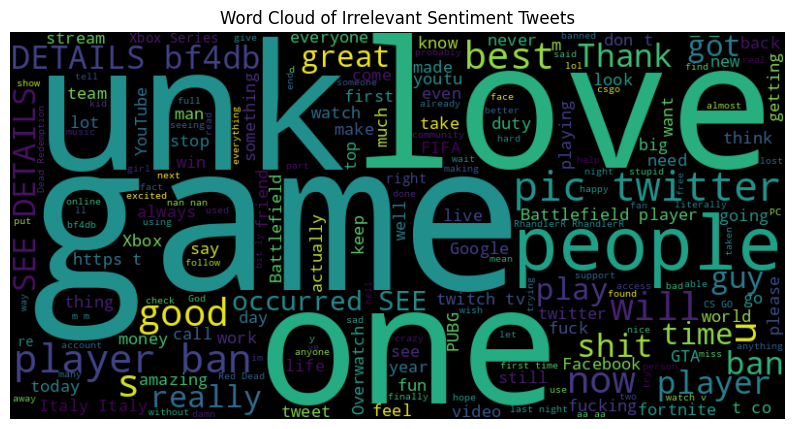

In [ ]:
irrelevant_tweets = Data_train[Data_train["Sentiment"] == "Irrelevant"]["Tweet_Content"]

# Join all the Irrelevant tweets into a single string
irrelevant_text = ','.join(irrelevant_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400).generate(irrelevant_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Irrelevant Sentiment Tweets')
plt.show()

<Axes: xlabel='Sentiment', ylabel='count'>

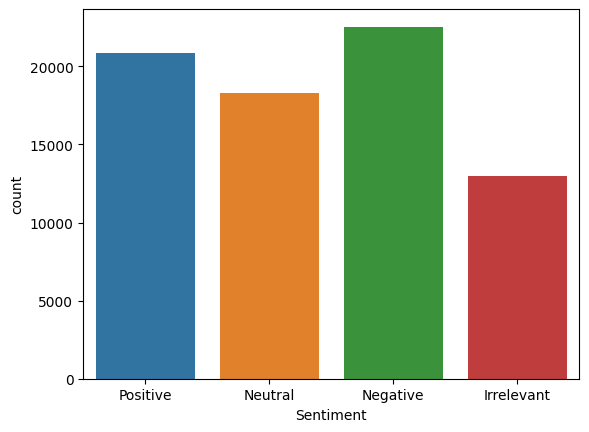

In [ ]:
sns.countplot(x=Data_train['Sentiment'])

In [ ]:
Data_train['text_lens']=Data_train['Tweet_Content'].apply(lambda x: len(x))
Data_valid['text_lens']=Data_valid['Tweet_Content'].apply(lambda x: len(x))

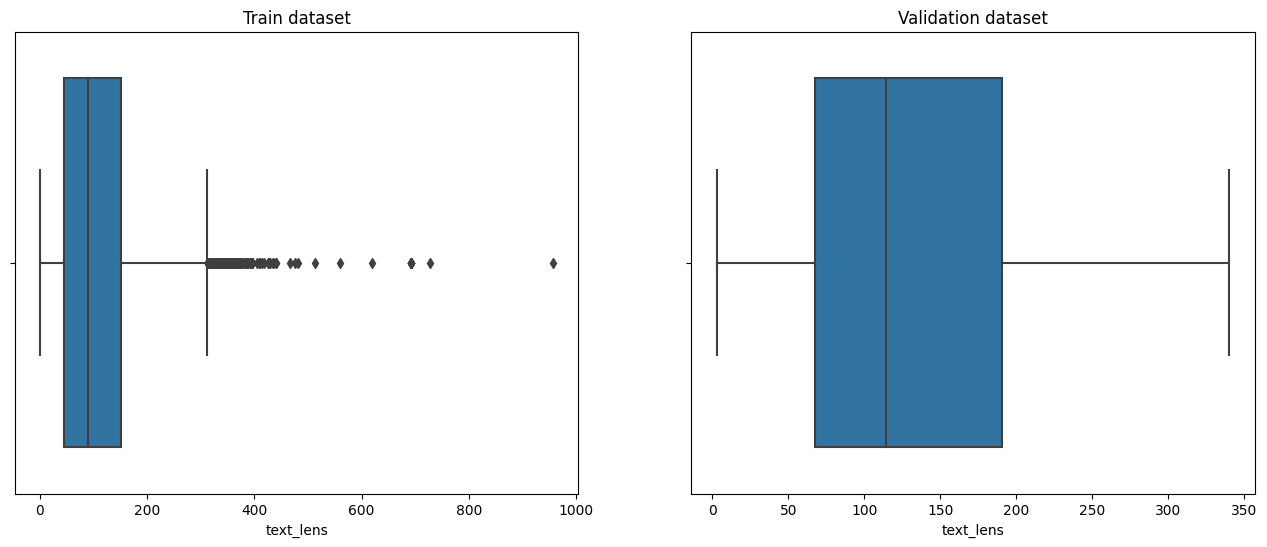

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(16,6))

sns.boxplot(data=Data_train,x='text_lens',ax=ax[0])
sns.boxplot(data=Data_valid,x='text_lens',ax=ax[1])

ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

# **Text Preprocessing**

In [ ]:
Data_train.drop(['Tweet_ID', 'Entity'], axis=1, inplace = True)
Data_valid.drop(['Tweet_ID', 'Entity'], axis=1, inplace = True)

In [ ]:
# checking nan values
print("\t\t\tTrain dataset")
print(Data_train.isna().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(Data_valid.isna().sum())

			Train dataset
Sentiment        0
Tweet_Content    0
text_lens        0
dtype: int64
****************************************
			Validation dataset
Sentiment        0
Tweet_Content    0
text_lens        0
dtype: int64


In [ ]:
# checking duplicated values
print("\t\t\tTrain dataset")
print(Data_train.duplicated().sum())
print("*"*40)
print("\t\t\tValidation dataset")
print(Data_valid.duplicated().sum())

			Train dataset
4909
****************************************
			Validation dataset
1


In [ ]:
# remove dupicate and nan values
Data_train.dropna(inplace=True)
Data_train.drop_duplicates(inplace=True)

In [ ]:
# remove dupicate and nan values
Data_valid.dropna(inplace=True)
Data_valid.drop_duplicates(inplace=True)

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming 'data' is your sentiment analysis dataset# Add a constant term to the data for the VIF calculation
data_with_const = add_constant(Data_train)

# Create a DataFrame to store the VIF resultsvif_data = pd.DataFrame()
vif_data["feature"] = data_with_const.columnsvif_data["VIF"] = [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])]

# View the VIF values for each feature
print(vif_data)

TypeError: ignored

In [ ]:
def remove_outlier(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = data.loc[(data[col_name] >= fence_low) & (data[col_name] <= fence_high)]
    return df_out

#remove outliers
Data_train = remove_outlier(Data_train,'text_lens')

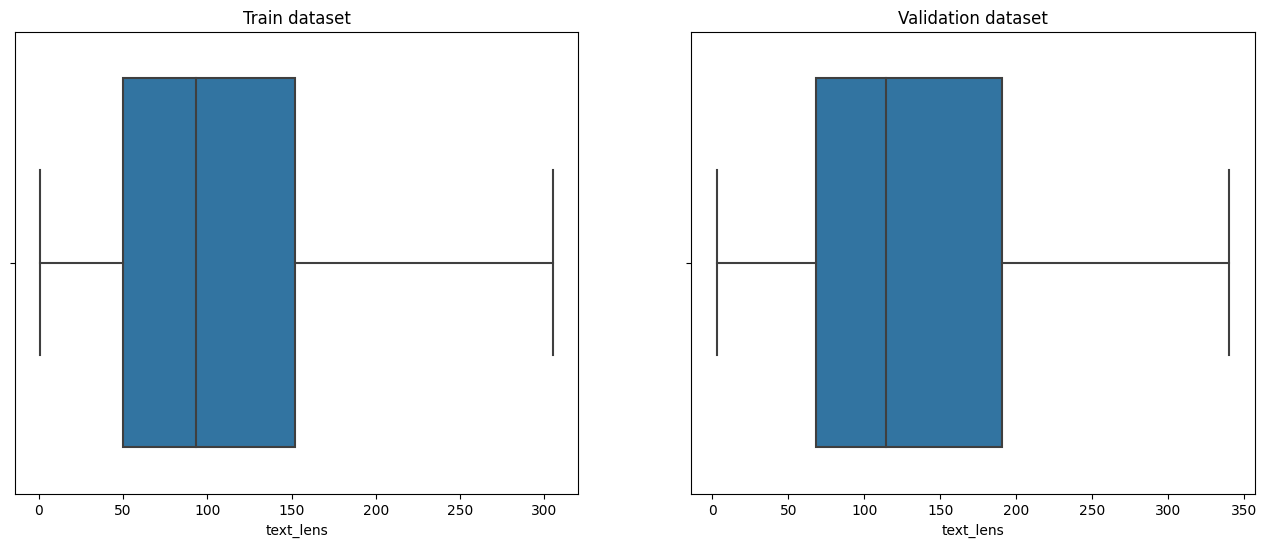

In [ ]:
fig , ax = plt.subplots(1,2,figsize=(16,6))

sns.boxplot(data=Data_train,x='text_lens',ax=ax[0])
sns.boxplot(data=Data_valid,x='text_lens',ax=ax[1])

ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

plt.show()

In [ ]:
Data_valid

,Sentiment,Tweet_Content,text_lens
0,Irrelevant,I mentioned on Facebook that I was struggling ...,242
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,109
2,Negative,@Microsoft Why do I pay for WORD when it funct...,91
3,Negative,"CSGO matchmaking is so full of closet hacking,...",71
4,Neutral,Now the President is slapping Americans in the...,170
...,...,...,...
995,Irrelevant,⭐️ Toronto is the arts and culture capital of ...,281
996,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,248
997,Positive,Today sucked so it’s time to drink wine n play...,120
998,Positive,Bought a fraction of Microsoft today. Small wins.,49


# **Model Building**

In [ ]:
import tensorflow
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer

#Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = TFRobertaModel.from_pretrained('roberta-base')

#Load and preprocess the data
data = Data_train[['Tweet_Content', 'Sentiment']]
data['Sentiment_label'] = pd.Categorical(data['Sentiment'])
data['Sentiment'] = data['Sentiment_label'].cat.codes

#Split the data into training and testing sets
data_train, data_test = train_test_split(data, test_size=0.3)

#Extract the training and testing texts and labels
train_texts = data_train['Tweet_Content'].tolist()
train_labels = data_train['Sentiment'].tolist()
test_texts = data_test['Tweet_Content'].tolist()
test_labels = data_test['Sentiment'].tolist()

#Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

#Convert the labels to one-hot encoding
num_labels = len(data['Sentiment_label'].cat.categories)
train_labels_encoded = tf.one_hot(train_labels, num_labels)
test_labels_encoded = tf.one_hot(test_labels, num_labels)

#Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels_encoded))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels_encoded))

#Define the model architecture
input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name='attention_mask')
output = model(input_ids, attention_mask=attention_mask)[0]
output = tf.keras.layers.Dense(num_labels, activation='softmax')(output[:, 0, :]) # Pooling the output
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

#Compile and train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

#Use smaller batch size
batch_size = 16

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.fit(train_dataset.batch(batch_size), epochs=2)

#Evaluate the model
model.evaluate(test_dataset.batch(batch_size))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.embeddings.position_ids', 'lm_head.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


 235/3007 [=>............................] - ETA: 11:31:36 - loss: 1.2209 - accuracy: 0.4721

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Make predictions on the training and test datasets
train_predictions = model.predict(Data_train.batch(64))
train_predicted_labels = np.argmax(train_predictions, axis=1)
test_predictions = model.predict(test_dataset.batch(64))
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
train_predicted_sentiments = Data_train['Sentiment_label'].cat.categories[train_predicted_labels]
test_predicted_sentiments = Data_train['Sentiment_label'].cat.categories[test_predicted_labels]

# Convert the true labels to their original sentiment categories
train_true_labels = dtrain['Sentiment_label']
test_true_labels = dtest['Sentiment_label']

# Calculate the classification report for the training set
train_classification_rep = classification_report(train_true_labels, train_predicted_sentiments)
print("Training Set - Classification Report:\n", train_classification_rep)

# Generate the confusion matrix for the training set
train_confusion_mat = confusion_matrix(train_true_labels, train_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(train_true_labels)

# Plot the confusion matrix for the training set
train_display = ConfusionMatrixDisplay(confusion_matrix=train_confusion_mat, display_labels=labels)
train_display.plot(cmap='Blues')
plt.title("Training Set - Confusion Matrix")
plt.grid(False)
plt.show()

# Calculate the classification report for the test set
test_classification_rep = classification_report(test_true_labels, test_predicted_sentiments)
print("Test Set - Classification Report:\n", test_classification_rep)

# Generate the confusion matrix for the test set
test_confusion_mat = confusion_matrix(test_true_labels, test_predicted_sentiments)

# Plot the confusion matrix for the test set
test_display = ConfusionMatrixDisplay(confusion_matrix=test_confusion_mat, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
# Load and preprocess the data
data_val = validation[['Tweet Content', 'Sentiment']]
data_val['Sentiment_label'] = pd.Categorical(data_val['Sentiment'])
data_val['Sentiment'] = data_val['Sentiment_label'].cat.codes





# Extract the training and testing texts and labels
val_texts = data_val['Tweet Content'].tolist()
val_labels = data_val['Sentiment'].tolist()

# Tokenize the texts
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Convert the labels to one-hot encoding
num_labels = len(data_val['Sentiment_label'].cat.categories)
val_labels_encoded = tf.one_hot(val_labels, num_labels)

# Create TensorFlow datasets
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels_encoded))

# Make predictions on the training and test datasets

val_predictions = model.predict(val_dataset.batch(64))
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Convert the predicted labels to their original sentiment categories
val_predicted_sentiments = data_val['Sentiment_label'].cat.categories[val_predicted_labels]

# Convert the true labels to their original sentiment categories
val_true_labels = data_val['Sentiment_label']

# Calculate the classification report for the training set
val_classification_rep = classification_report(val_true_labels, val_predicted_sentiments)
print("Training Set - Classification Report:\n", val_classification_rep)

# Generate the confusion matrix for the training set
val_confusion_mat = confusion_matrix(val_true_labels, val_predicted_sentiments)

# Get the unique labels/categories from the true labels
labels = np.unique(val_true_labels)

# Plot the confusion matrix for the training set
val_display = ConfusionMatrixDisplay(confusion_matrix=val_confusion_mat, display_labels=labels)
val_display.plot(cmap='Blues')
plt.title("Validation Set - Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
#@title 1. Keep this tab alive to prevent Colab from disconnecting you { display-mode: "form" }

#@markdown Press play on the music player that will appear below:
%%html
<audio src="https://oobabooga.github.io/silence.m4a" controls>